In [478]:
import sys,os
sys.path.append("../TI_modules/")
import TI_greensfn_parallel as TI_greensfn
import multiprocessing as mp
from scipy import linalg as sci_linalg
import time
import itertools
from scipy.sparse import csr_matrix

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
figpath="../results/figures/"
ensure_dir(figpath)

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [459]:
TIG0=TI_greensfn.init_material(npix=60,pixwid=0.2e-9)

<IPython.core.display.Javascript object>


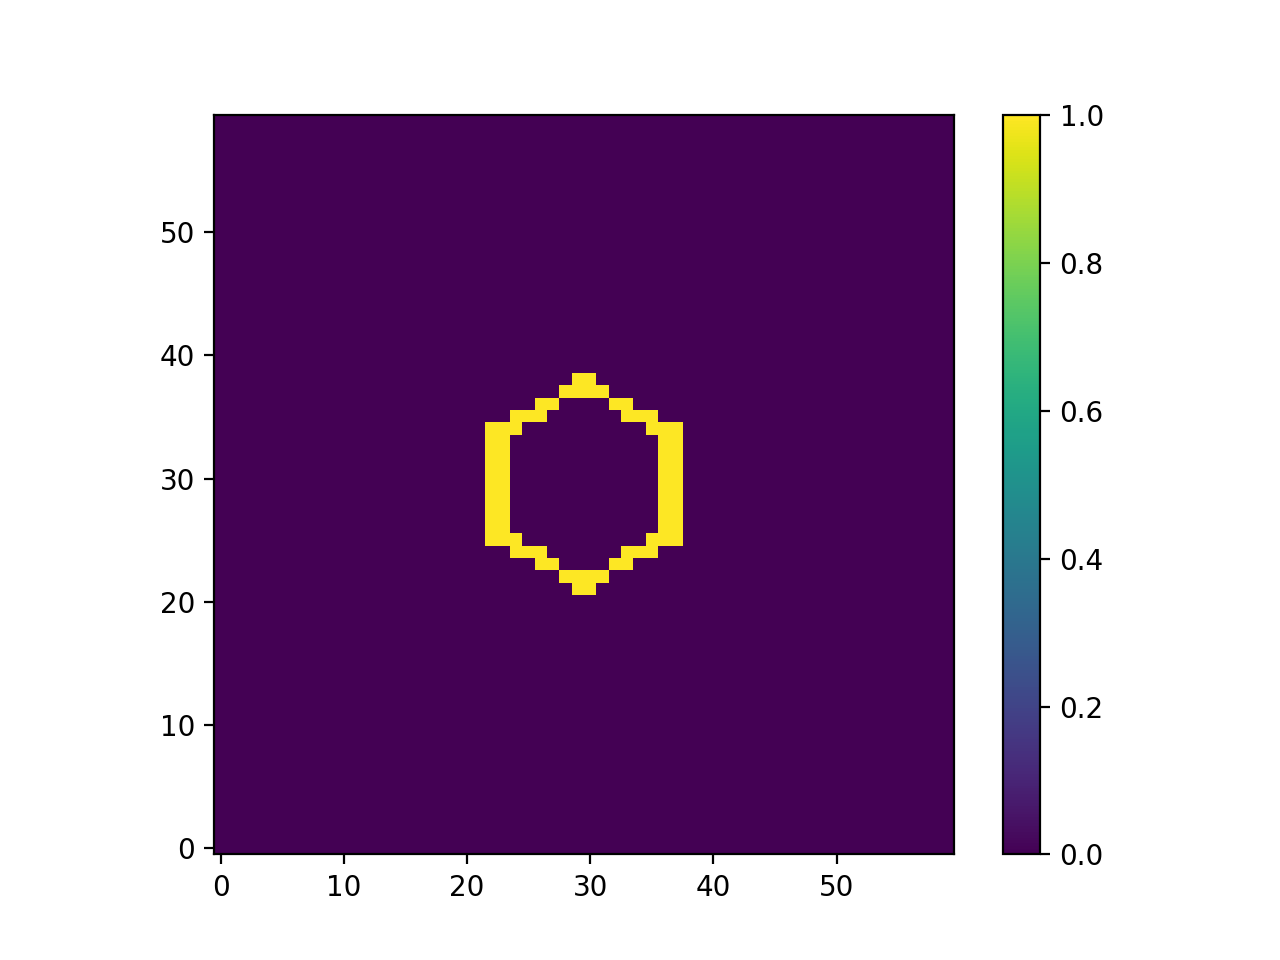

In [460]:
npix=TIG0.npix
pad=0.01
x0=np.linspace(-1.,1.,npix)
y0=np.linspace(-1.,1.,npix)
cidx=[t for t in itertools.product(np.arange(npix),np.arange(npix))]
coord=[t for t in itertools.product(x0,y0)]


def hexagonal_well(V0=5,rad=1):
    V=np.zeros(npix**2,float)
    def hexagon(pos):
        s=x0[npix-int(np.ceil(pad*npix))]
        x, y = map(abs, pos)
        return y < 3**0.5 * min(s*rad - x, s*rad / 2)
    
    for i,xy in enumerate(coord):
        if not(hexagon(xy)):
            V[i]=1.
    V=V0*V/max(V)-V0
    return V
    
def return_2D_V(V0=5,rad=1):
    V=hexagonal_well(V0=V0,rad=rad)
    temp_V=np.zeros((npix,npix),float)
    for i,c in enumerate(cidx):
        temp_V[c]=V[i]
    return temp_V

V2d=return_2D_V(rad=0.3,V0=-1) - return_2D_V(rad=0.25,V0=-1)

figure()
imshow(V2d,origin="lower")
colorbar()

<IPython.core.display.Javascript object>


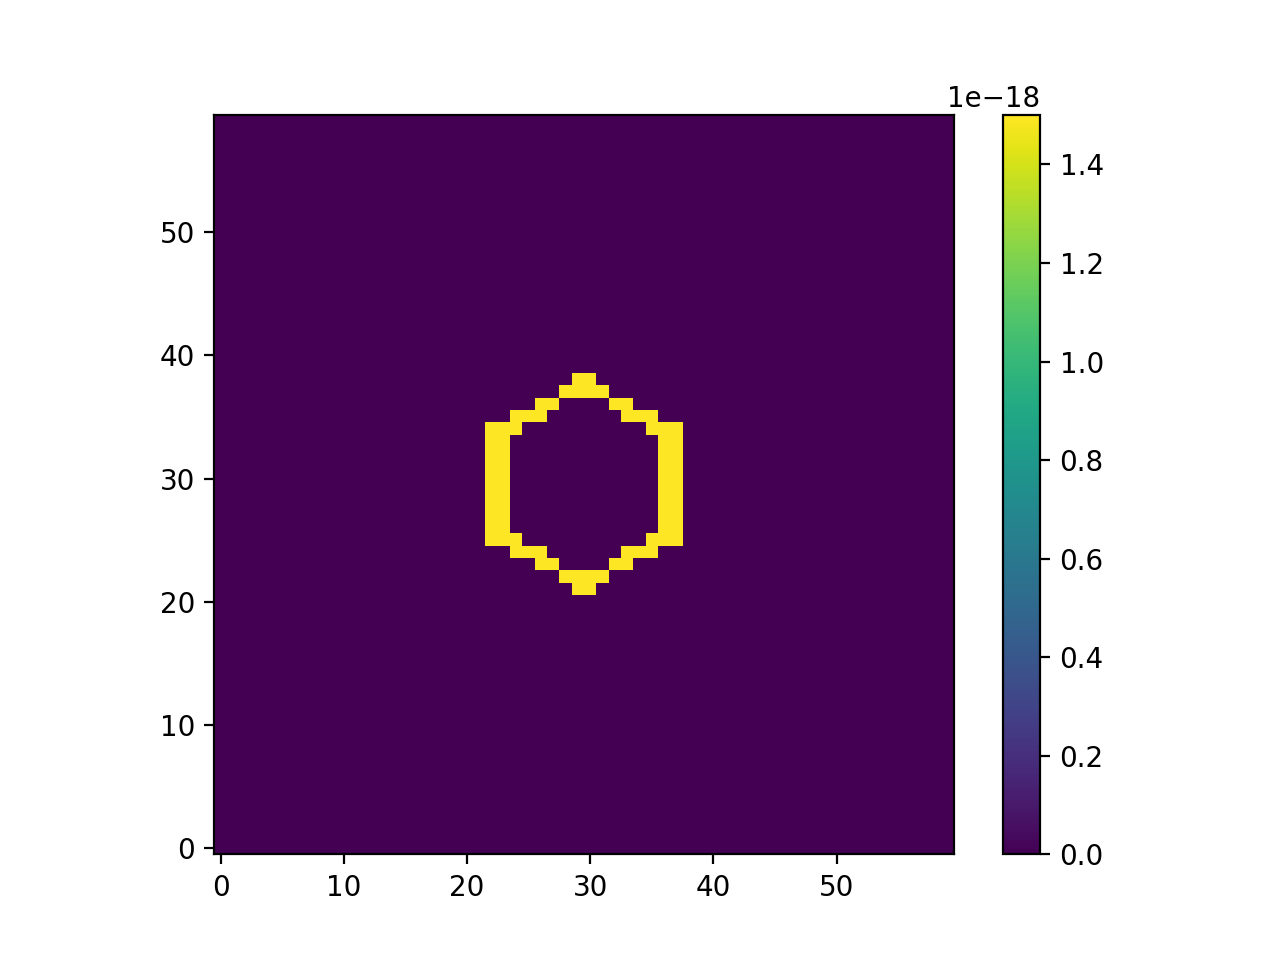

In [461]:
TIG0.setup_potential(vamp=1.5e-18)
TIG0.V=V2d*1.5e-18
TIG0.Vall=np.kron(np.diag(TIG0.V.ravel()),TI_greensfn.cnst.sigma0)
figure()
imshow(abs(TIG0.V),origin="lower")
colorbar()

<IPython.core.display.Javascript object>


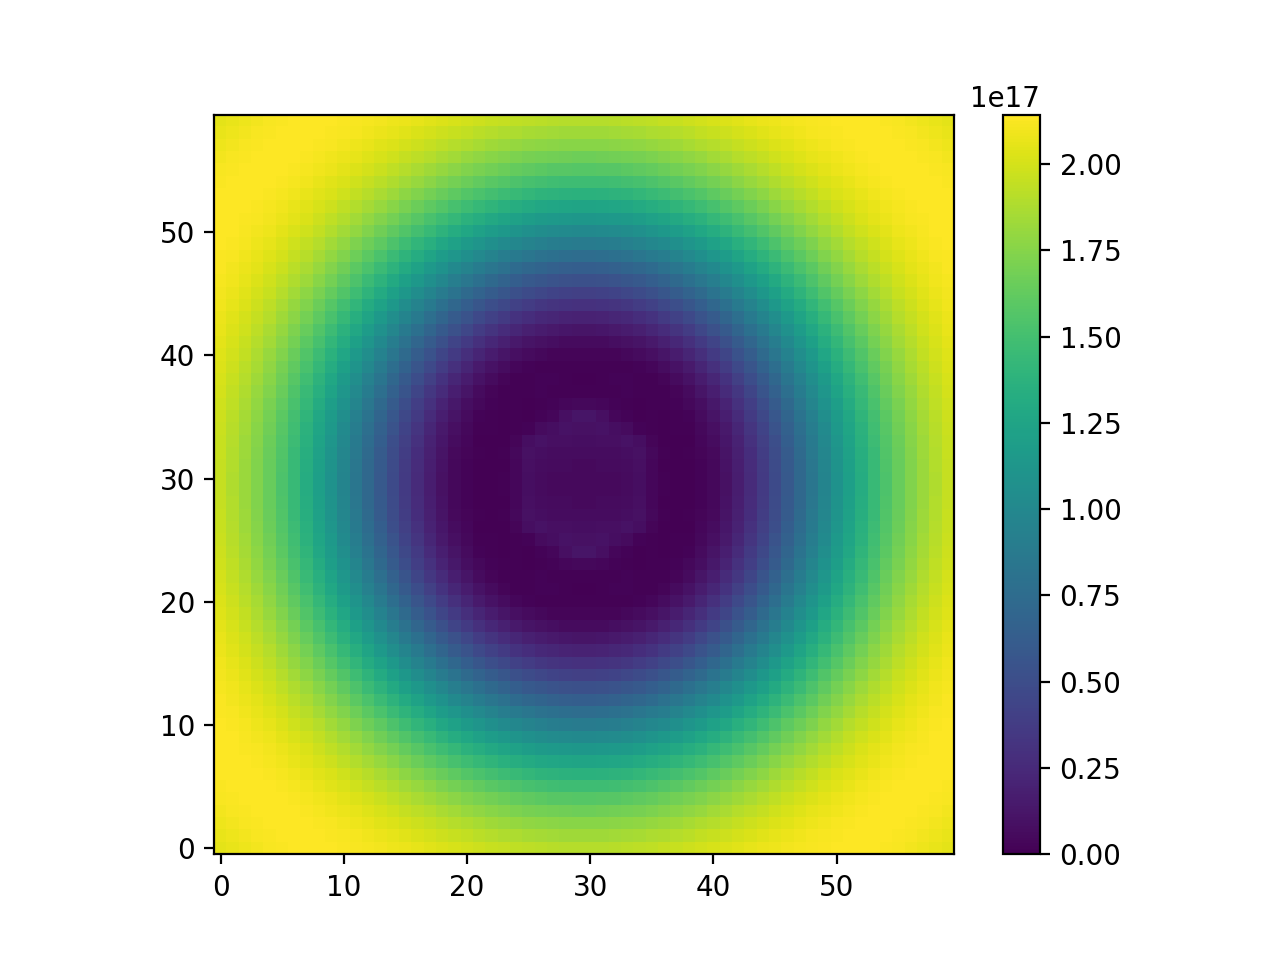

In [462]:
# G0all=TIG0.gen_G0_all(E=0.1)
# figure()
# imshow(log10(abs(G0all)),origin="lower")
# colorbar()

ldos=TIG0.get_ldos(E=-0.1)
figure()
imshow(ldos,origin="lower")
colorbar()

In [333]:
def run_fn(E):
    ldos=TIG0.get_ldos(E=E,loc=[])
    return ldos

def run_ldos_in_parallel(numprocs):
    pool=mp.Pool(processes=numprocs)
    ldos=pool.map(run_fn,E)
    pool.close()
    pool.join()
    return ldos

In [387]:
E=linspace(-0.25,0.25,60)

# ldos=np.zeros_like(E)
# for i,omega in enumerate(E):
#     ldos[i]=TIG0.get_ldos(E=omega,loc=[20,20])
#     print i,omega,ldos[i]


ldos=run_ldos_in_parallel(6)
ldos=np.array(ldos)

<IPython.core.display.Javascript object>


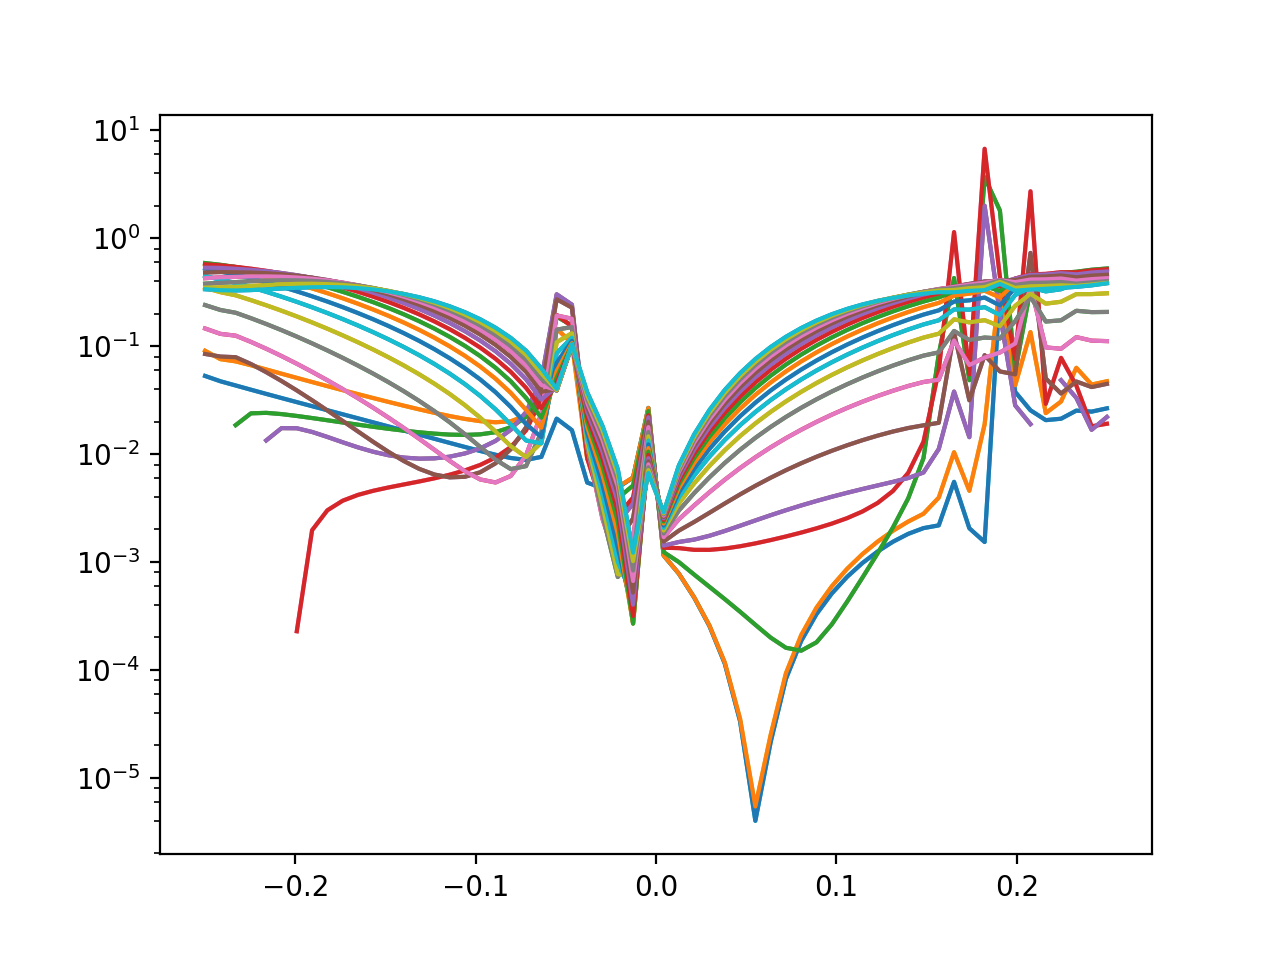

[]

In [388]:
ion()
figure()
for i in range(TIG0.npix):
    plot(E,ldos[:,i,i]/1e18)
semilogy()

In [389]:
ioff()
for i,omega in enumerate(E):
    figure()
    imshow(ldos[i,]/1e18,origin="lower")
    title(r"$\epsilon=$" + str(round(omega,2)) + " eV")
    colorbar()
    filename=figpath + "ldos_" + str(i).zfill(2) + ".jpeg"
    savefig(filename,bbox_inches="tight")

workdir=os.getcwd()
os.chdir(figpath)
cmd="convert -quality 99 -density 150 -delay 40 -loop 0 ldos_*.jpeg ldos_evolve.gif"
print cmd
os.system(cmd)
os.chdir(workdir)

convert -quality 99 -density 150 -delay 40 -loop 0 ldos_*.jpeg ldos_evolve.gif


In [516]:
start=time.time()
G0=TIG0.gen_G0_all(E=0.2)
print time.time()-start
G0V=np.einsum("ij,jj->ij",G0,TIG0.Vall)
I0=np.identity(2*TIG0.npix**2,dtype=np.complex)
A=(I0-G0V).T

23.7374150753


In [455]:
# start=time.time()
# oldTt=sci_linalg.solve(A,TIG0.Vall)
# print time.time()-start

2.50970005989


In [512]:
start=time.time()
Tt=np.zeros_like(TIG0.Vall)
nz_idx=nonzero(TIG0.Vall)[0]
temp=sci_linalg.solve(A,TIG0.Vall[:,nz_idx])
for i,idx in enumerate(nz_idx):
    Tt[:,idx]=temp[:,i]
    
G0T=np.einsum("ij,jj->ij",G0,Tt)
nz_idx=nonzero(G0T[0,:])[0]
G0TG0=np.matmul(G0T[:,nz_idx],G0[nz_idx,:])
G= G0 + G0TG0
LDOS=(-1./np.pi)*np.imag((np.diagonal(G)[1::2] + np.diagonal(G)[::2]).reshape(TIG0.npix,TIG0.npix))
print time.time()-start

10.1990950108


In [513]:
start=time.time()
Tt=np.zeros_like(TIG0.Vall)
nz_idx=nonzero(TIG0.Vall)[0]
temp=sci_linalg.solve(A,TIG0.Vall[:,nz_idx])
for i,idx in enumerate(nz_idx):
    Tt[:,idx]=temp[:,i]

Tt_sparse=csr_matrix(Tt)
TG0=Tt_sparse.dot(G0)
nz_idx=nonzero(TG0[:,0])[0]
G0TG0=np.matmul(G0[:,nz_idx],TG0[nz_idx,:])
G= G0 + G0TG0
LDOS_new1=(-1./np.pi)*np.imag((np.diagonal(G)[1::2] + np.diagonal(G)[::2]).reshape(TIG0.npix,TIG0.npix))
print time.time()-start

12.7222211361


In [514]:
start=time.time()
G=np.linalg.solve(I0-G0V,G0)
LDOS_new=(-1./np.pi)*np.imag((np.diagonal(G)[1::2] + np.diagonal(G)[::2]).reshape(TIG0.npix,TIG0.npix))
print time.time()-start

31.9570641518


<IPython.core.display.Javascript object>


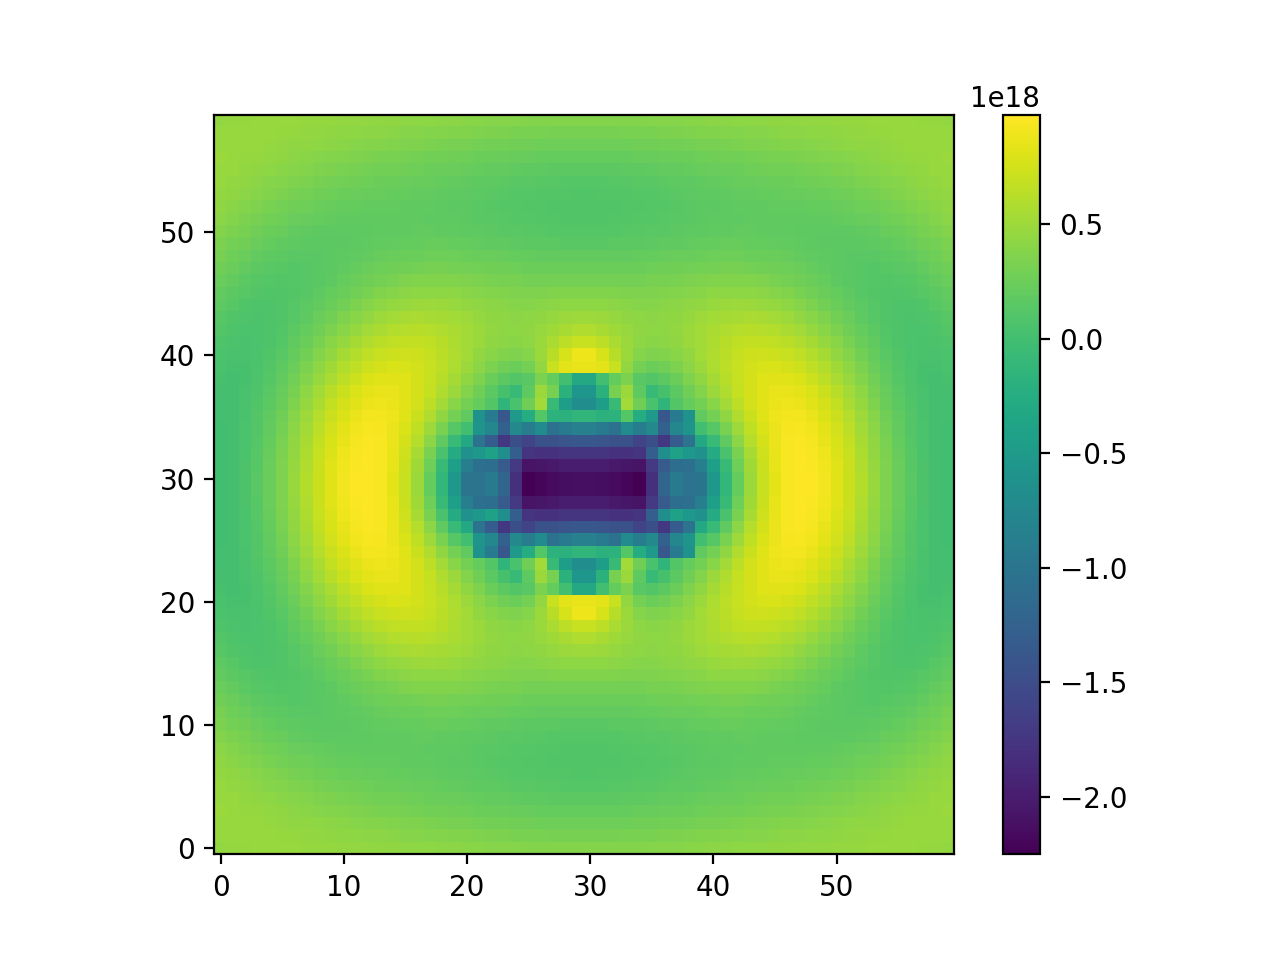

<IPython.core.display.Javascript object>


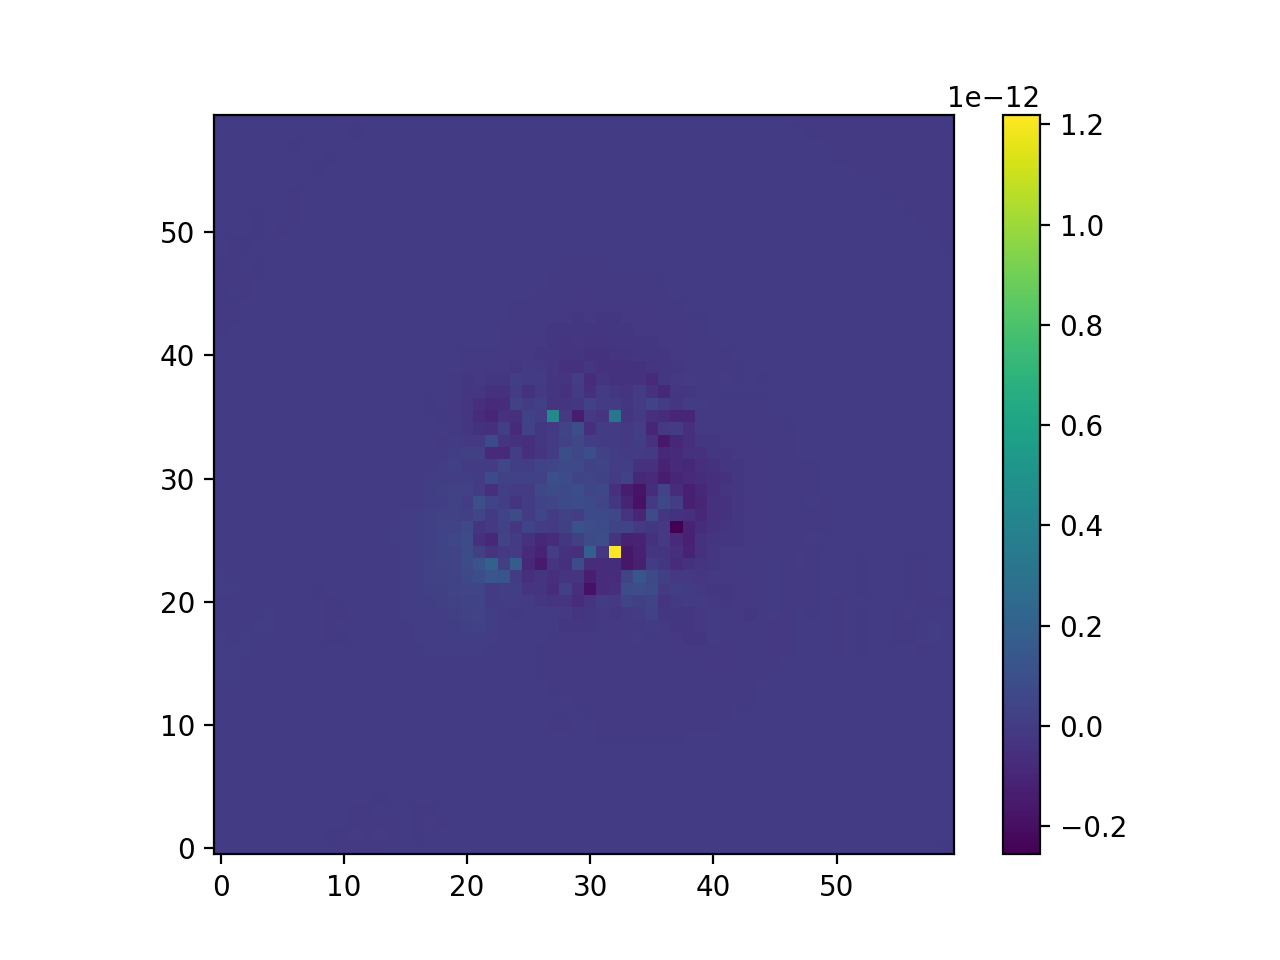

<IPython.core.display.Javascript object>


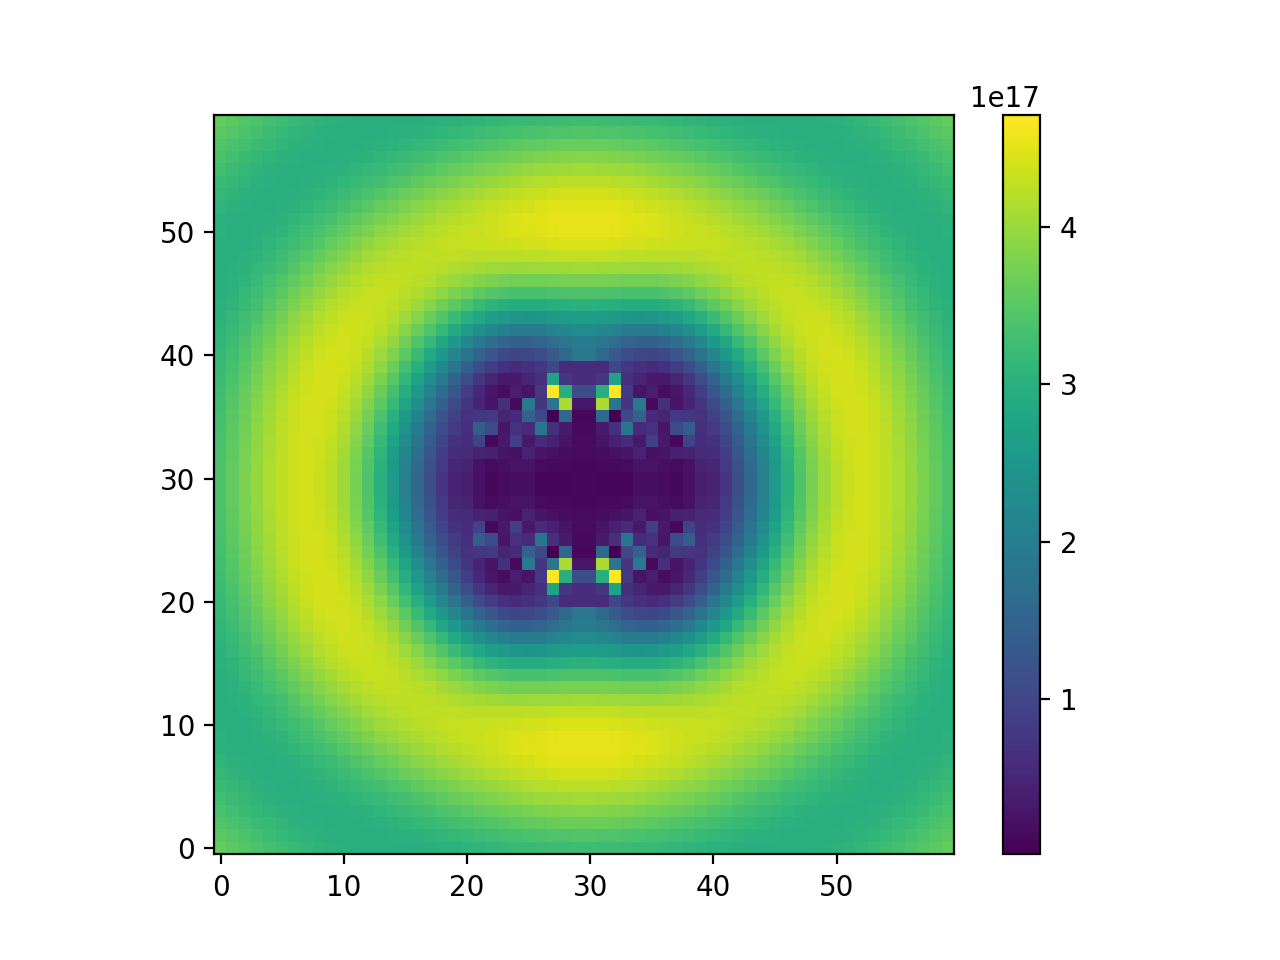

In [518]:
figure()
imshow(LDOS,origin="lower")
colorbar()

figure()
imshow((LDOS_new1-LDOS_new)/LDOS_new,origin="lower")
colorbar()

figure()
imshow(LDOS_new,origin="lower")
colorbar()